(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

**using vader sentiment library, accurate but slow, it takes about 90 seconds to process 10k reviews.**

In [36]:
import os
import json
import unicodedata
import time
# this line might make the output goes to terminal instead of webpage
# os.system('pip install vaderSentiment')
from vaderSentiment.vaderSentiment import sentiment as vaderSentiment
#open file
reviewFile = open(
        './yelp_dataset/yelp_academic_dataset_review.json',
        'r'
)
os.system("rm vader_score_dataframe.csv")
os.system("touch vader_score_dataframe.csv")
score_df = open('vader_score_dataframe.csv', 'r+b')
#create header
columns = ['review_id','star','calculated_id']
writerFile = csv.writer(score_df, delimiter=',')
writerFile.writerow(columns)
i = 0
start_time = time.time()
for line in reviewFile:
    json_dict = json.loads(line)
    review_id = json_dict['review_id']
    stars = json_dict['stars']
    review_string = json_dict['text']
    review_string = unicodedata.normalize('NFKD', review_string).encode('ascii','ignore').lower()
    review_score = vaderSentiment(review_string)['compound']
    review_score = review_score * 2.5 + 2.5
    i = i + 1
    if i % 10000 == 0:
        print i / 1000
        print time.time() - start_time
        start_time = time.time()
    #write to df 
    writerFile.writerow([review_id, stars, review_score])

KeyboardInterrupt: 

**down below is my own implementation, faster(12sec for 10k reviews) but not that accurate.  I tried both stem and not stem the review, but the result without stem gives a more accurate corelation so I will not use stem here.**

corr using stemming:
               star  calculated_id
star           1.000000       0.296924
calculated_id  0.296924       1.000000

corr without stemming:
               star  calculated_id
star           1.000000       0.458999
calculated_id  0.458999       1.000000

corr using vader stem:
                   star  calculated_id
star           1.000000       0.604476
calculated_id  0.604476       1.000000


In [11]:
##########################################################################################
# this block is used for file and lexicon init
##########################################################################################
from nltk.stem.porter import PorterStemmer
import pandas as pd
from pandas import DataFrame
import numpy as np
import unicodedata
import json
import csv
import os

porter = PorterStemmer()
#open files
reviewFile = open(
        './yelp_dataset/yelp_academic_dataset_review.json',
        'r'
)
lexion_pos = open(
    './positive-words.txt',
    'r'
)
lexion_neg = open(
    './negative-words.txt',
    'r'
)

#initialize lexicon
pos_lst = np.array([])
neg_lst = np.array([])

for line in lexion_pos:
    if line[0] is not ';':
        pos_lst = np.append(pos_lst, line[:-1])
    else:
        pass
    
for line in lexion_neg:
    if line[0] is not ';':
        neg_lst = np.append(neg_lst, line[:-1])
    else:
        pass

print pos_lst
print neg_lst

['' 'a+' 'abound' ..., 'zenith' 'zest' 'zippy']
['' '2-faced' '2-faces' ..., 'zealous' 'zealously' 'zombie']


In [13]:
##########################################################################################
# readfile by line and calc score, save to a dataframe
##########################################################################################
import time

#calculate score for a single review
def calc_line(review_string, print_bool):
    start_time = time.time()
    review_score = 0.0
    #apply porter stemming to review string
    porter = PorterStemmer()
#     review_string = porter.stem(review_string)
    review_string = unicodedata.normalize('NFKD', review_string).encode('ascii','ignore').lower()
    review_token_lst = whitespace_tokenize(review_string)
    if print_bool:
        time1 = time.time()
        print '    2.1: ' + str(time1 - start_time)
    pos_words = np.intersect1d(review_token_lst, pos_lst)
    neg_words = np.intersect1d(review_token_lst, neg_lst)
    review_score = review_score + len(pos_words) - len(neg_words)
    if print_bool:
        time2 = time.time()
        print '    2.2: ' + str(time2 - time1)
    #normalize to 0~5
    if len(pos_words) + len(neg_words) is not 0:
        review_score = (review_score * 2.5) / (1.0 * len(pos_words) + len(neg_words)) + 2.5
    else:
        review_score = 0
    del(pos_words)
    del(neg_words)
    if print_bool:
        time3 = time.time()
        print '    2.3: ' + str(time3 - time2)
        print '    --------------------------'
    return review_score

#tokenize function
def whitespace_tokenize(review_string):
    review_token_lst = review_string.split(' ')
    return np.array(review_token_lst)

#calculate score for whole dataset
def calc_score(reviewFile):
    #open file
    os.system("rm score_dataframe.csv")
    os.system("touch score_dataframe.csv")
    score_df = open('score_dataframe.csv', 'r+b')
    #create header
    columns = ['review_id','star','calculated_id']

    writerFile = csv.writer(score_df, delimiter=',')
    writerFile.writerow(columns)
    
    start_time = time.time()
    one_k_time = time.time()
    i = 0
    for line in reviewFile:
        start_time = time.time()
        i = i + 1
        json_dict = json.loads(line)
        review_id = json_dict['review_id']
        stars = json_dict['stars']
        review_string = json_dict['text']
        review_score = calc_line(review_string, False)
        #write to df 
        writerFile.writerow([review_id, stars, review_score])
        if i % 10000 == 0:
            print i / 1000
            print time.time() - one_k_time
            one_k_time = time.time()

In [14]:
#starts at 5:25pm , ends at 6:12pm
calc_score(reviewFile)

10
11.9759380817
20
11.9399290085
30
11.6343400478
40
11.319467783
50
11.3351027966
60
11.32482481
70
12.144466877
80
12.5573279858
90
11.5432031155
100
11.2143750191
110
11.1610958576
120
11.4517550468
130
11.3001599312
140
11.2118070126
150
11.2222499847
160
11.1628460884
170
11.143903017
180
11.1799240112
190
11.1590960026
200
11.219274044
210
11.2028520107
220
11.1929819584
230
11.2062220573
240
11.1845510006
250
11.1708779335
260
11.1790969372
270
11.1617200375
280
11.2075870037
290
11.2171089649
300
11.2929189205
310
11.1754579544
320
11.2145090103
330
11.2317359447
340
11.2487368584
350
11.188062191
360
11.203551054
370
11.1539311409
380
11.2532088757
390
11.2433068752
400
11.7954120636
410
11.2891800404
420
11.236194849
430
11.2455761433
440
11.2740809917
450
11.2380669117
460
11.1847679615
470
11.250565052
480
11.2593569756
490
11.221722126
500
11.3494539261
510
11.3880939484
520
11.3131768703
530
11.9286539555
540
11.8632421494
550
11.274119854
560
11.2718770504
570
11.288348

Visualization and short (detailed) analysis. **(10 pts)**

In [40]:
#read both dataframe and visualize
import pandas as pd
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#read dataframe, print corr and sort
review_df = pd.read_csv('./score_dataframe.csv')
print review_df.corr()
review_df = review_df.sort(['star', 'calculated_id'], ascending=[1 , 1])

(0, 6)

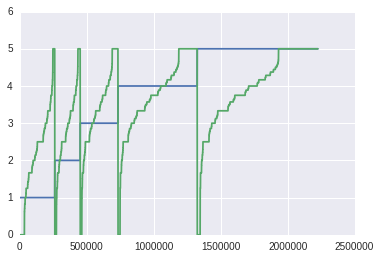

In [19]:
#plot data frame
star = np.array(review_df.star.values)
score = np.array(review_df.calculated_id.values)
plt.plot(star)
plt.plot(score)
plt.ylim(0 , 6)

**Analysis:**
  
  We can see from the graph that the accuracy is not very ideal, and for those reviews that give 5 stars the accuracy is higher than others.  
  
  The score we got from sentiment analysis here is actually the ratio of pos word and neg words.  In those reviews that has 5 stars and 5 calculated scores, there must be no negative words in the review text.  However there might be negation works like "not bad" but the word "bad" is calculated as a negative word so there might be cases that people give 5 stars and we got like 3 or 4 for calculated scores. 
  
  Also there might be people giving 1 or two stars but has a pretty high score, sometimes even 5, in this case negation is also a possible answer, and some people prefer not to use too much negative words, instead they might use "they lost my business for good" in which good might be considered a positive word.

-----------------

Now, let's look at Business Objects. Try to find **culinary districts in Las Vegas**. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to **cluster closeness**. Use "categories" and "attributes" to **cluster for similarity**.

Find clusters using the 3 different techniques we discussed in class: **k-means++**, **hierarchical**, and **GMM**. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The **spatial coordinates** and **restaurant categories/attributes** have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

In [1]:
##########################################################################################
# preprocess dataframe, filter restaurant in LasVegas into a dataframe
##########################################################################################
import json
import csv
import os
import unicodedata
import pandas as pd
import numpy as np
#calc attribute value and store them as an int
#when retrieving it, for int a and int b, 
#bin(a ^ b).count("1") is the hamming distance
#currently the hamming distance for attributes will be 0 to 5
def calc_attrib(attrib_dict):
    score = 0
    if 'Delivery' in attrib_dict and attrib_dict['Delivery']:
        score = score + 1
    score = score * 2
    if 'Accepts Credit Cards' in attrib_dict and  attrib_dict['Accepts Credit Cards']:
        score = score + 1
    score = score * 2
    if 'Take-out' in attrib_dict and  attrib_dict['Take-out']:
        score = score + 1
    score = score * 2
    if 'Wi-Fi' in attrib_dict and  attrib_dict['Wi-Fi'] == u'no':
        score = score + 1
    score = score * 2
    if 'Waiter Service' in attrib_dict and  attrib_dict['Waiter Service']:
        score = score + 1
    return score
    
#get data filtered
def get_restaurants():
    business_file = open('./yelp_dataset/yelp_academic_dataset_business.json' , 'r')
    i = 0
    #create csv file for restaurants
    os.system("rm restaurant_dataframe.csv")
    os.system("touch restaurant_dataframe.csv")
    restaurant_df = open('restaurant_dataframe.csv', 'r+b')

    #open csv file for restaurants
    columns = ['name', 'latitude', 'longitude', 'categories', 'bool_attrib']
    writerFile = csv.writer(restaurant_df)
    writerFile.writerow(columns)
    for line in business_file:
        tempDict = json.loads(line)
        if tempDict['city'] == u'Las Vegas':
            if u'Restaurants' in tempDict['categories']:
                i = i + 1
                ascii_list = ''
                for cat in tempDict['categories']:
                    ascii_list += str(cat)
                    ascii_list += ';'
                #write to df 
                writerFile.writerow([
                    unicodedata.normalize('NFKD', tempDict['name']).encode('ascii','ignore'),
                    tempDict['latitude'],
                    tempDict['longitude'],
                    ascii_list,
                    calc_attrib(tempDict['attributes'])
                ])
    business_file.close()
get_restaurants()

In [2]:
##########################################################################################
# functions for calculating distance
##########################################################################################
#calculate attribute distance(0-1) 0 is similar
def calc_dist_attrib(a , b):
    return bin(a ^ b).count("1") * 1.0 / 5

#calculate space diatance(1000 * dist^2)/17 => (0-10) 0 is closest
def calc_dist_space(x1, y1, x2, y2):
    return (1000 * ((x1 - x2) * (x1 - x2) + (y1 - y2) * (y1 - y2))) / 17

#calculate category(0-1) 0 is similar
def calc_dist_category(lst1 , lst2):
    return (1 - len(set(lst1) & set(lst2)) / len(set(lst1) | set(lst2)))

In [42]:
##########################################################################################
# Calculate dist_array, takes about 400 seconds to complete
##########################################################################################
import time

#open file 
dist_df = pd.read_csv("./restaurant_dataframe.csv")
lon = dist_df.longitude
lat = dist_df.latitude
dist = dist_df.bool_attrib
cat = dist_df.categories

start = time.time()
# init dist_array
dist_array = np.zeros((len(dist_df), len(dist_df)))
for i in range(0 , len(dist_df)):
    for j in range(i, len(dist_df)):
        tempDist = 0.0
        tempDist += calc_dist_space(lon[i], lat[i], lon[j], lat[j])
        tempDist += calc_dist_attrib(dist[i] , dist[j])
        tempDist += calc_dist_category(
                        cat[i].split(';'), 
                        cat[j].split(';')
                    )
        dist_array[i][j] = tempDist
print time.time() - start
dist_array = dist_array + dist_array.T

Visualize your clusters using **each technique**. Label your clusters. **(10 pts)**

In [43]:
##########################################################################################
# read data frame and init colors, 
# following blocks still need dist_array generated in previous block
##########################################################################################

import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline

restaurant_df = pd.read_csv('./restaurant_dataframe.csv')
colors = ['#0000FF', '#00FF00', '#FF0000', '#FFFF00', '#00FFFF',
          '#FF00FF', '#7777FF', '#FF7777', '#FF77FF', '#5B8324']

In [5]:
#hierarchical
import scipy.cluster.hierarchy as hr
start_time = time.time()
ck = hr.fcluster(hr.linkage(dist_array, method='complete'), 128, 'distance')
print time.time() - start_time

72.465236187


In [6]:
#plot hierarchical
import gmplot
ck = ck.astype(np.int)
latitude = restaurant_df.latitude
longitude = restaurant_df.longitude

#divide group then scatter using different colors
testLat = [[] for i in range(0 , 10)]
testLong = [[] for i in range(0 , 10)]
for i in range(0 , len(restaurant_df)):
    testLat[ck[i]].append(latitude[i])
    testLong[ck[i]].append(longitude[i])
#coordinate from googlemap url
gmap = gmplot.GoogleMapPlotter(36.1778674, -115.2306257, 11)

for i in range(0 , 10):
    gmap.scatter(testLat[i], testLong[i], colors[i], marker=False)
gmap.draw("hr_map.html")

In [7]:
#GMM
from sklearn import mixture
start_time = time.time()
gmm = mixture.GMM(n_components=8, covariance_type='diag')
gmm.fit(dist_array)
pred = gmm.predict(dist_array)
print time.time() - start_time

18.5939450264


In [8]:
#plot GMM
import gmplot
pred = pred.astype(np.int)
# for i in range(0, len(restaurant_df)):
latitude = restaurant_df.latitude
longitude = restaurant_df.longitude

#divide group then scatter using different colors
testLat = [[] for i in range(0 , 10)]
testLong = [[] for i in range(0 , 10)]
for i in range(0 , len(restaurant_df)):
    testLat[pred[i]].append(latitude[i])
    testLong[pred[i]].append(longitude[i])
gmap = gmplot.GoogleMapPlotter(36.1778674, -115.2306257, 11)

for i in range(0 , 10):
    gmap.scatter(testLat[i], testLong[i], colors[i], marker=False)
gmap.draw("gmm_map.html")

In [9]:
#kmeans++
start_time = time.time()
kmeans = KMeans(init='k-means++', n_clusters=8, n_init=10)
kmeans.fit_predict(dist_array)
labels = kmeans.labels_
print time.time() - start_time

14.5488920212


In [22]:
print labels

[4 1 7 ..., 2 6 2]


In [10]:
#plot kmeans
import gmplot
labels = labels.astype(np.int)
# for i in range(0, len(restaurant_df)):
latitude = restaurant_df.latitude
longitude = restaurant_df.longitude

#divide group then scatter using different colors
testLat = [[] for i in range(0 , 10)]
testLong = [[] for i in range(0 , 10)]
for i in range(0 , len(restaurant_df)):
    testLat[labels[i]].append(latitude[i])
    testLong[labels[i]].append(longitude[i])
gmap = gmplot.GoogleMapPlotter(36.1778674, -115.2306257, 11)

for i in range(0 , 10):
    gmap.scatter(testLat[i], testLong[i], colors[i], marker=False)
gmap.draw("kmeans_map.html")

Now let's **detect outliers**. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

In [79]:
#outlier detect using the result of kmeans
dist = kmeans.transform(dist_array)

range_list = []
for i in range(0, 4658):
    range_list.append(dist[i][labels[i]])

#get the indices for top 10 outliers
idx = np.argsort(range_list)
top10_outlier_idx = idx[-10:]
print 'the top 10 winners are:' + str(top10_outlier_idx)

#plot the top 10 outliers on google map
gmap = gmplot.GoogleMapPlotter(36.1778674, -115.2306257, 11)
testLat = []
testLong = []
for i in range(0 , 10):
    testLat.append(latitude[top10_outlier_idx[i]])
    testLong.append(longitude[top10_outlier_idx[i]])
for i in range(0 , 10):
    gmap.scatter(
        testLat, 
        testLong, 
        colors[2], 
        size=100,
        marker=False)
gmap.scatter(latitude, longitude, colors[1], marker=False)
gmap.draw("outliers_map.html")


#get whole information for the 10 outliers
def get_restaurants2():
    business_file = open('./yelp_dataset/yelp_academic_dataset_business.json' , 'r')

    restaurant_dict_lst = []
    for line in business_file:
        tempDict = json.loads(line)
        if tempDict['city'] == u'Las Vegas':
            if u'Restaurants' in tempDict['categories']:
                restaurant_dict_lst.append(tempDict)
    business_file.close()
    return restaurant_dict_lst
dict_df = pd.DataFrame(get_restaurants2())
for i in range(0, 10):
    print dict_df.loc[top10_outlier_idx[i]]

the top 10 winners are:[1716 2368 3519 1878 4139 3420  379 2895 3188 2062]
attributes       {u'Take-out': True, u'Alcohol': u'none', u'Noi...
business_id                                 TtH0iIGIS310JfaEbQy-LQ
categories                                    [Cafes, Restaurants]
city                                                     Las Vegas
full_address     Nellis AFB\n5941 Fitzgerald Blvd\nLas Vegas, N...
hours                                                           {}
latitude                                                   36.2422
longitude                                                 -115.045
name                                            Rickenbackers Cafe
neighborhoods                                                   []
open                                                          True
review_count                                                     4
stars                                                            4
state                                                 

In these 10 outliers, only 4 business has more than 10 reviews.  And no one of the has 5 stars.  There is basically nothing in common among these 10 restaurants if you look into their categories and also, they lies in different direction of the city.  But there's one thing in common: except three restaurant are near AirForce Base, the others lies right beside the highway exit.

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

  In these three techniques, GMM and KMeans can easily control how many clusters you will get, but when using Hierarchical you need to control the threshold argument so that you could increase or decrease the output clusters.
  From time efficiency, GMM and KMeans takes about 15 seconds, but hierarchical takes more than 1 minutes.
  In the result of clustering, three technique has different result.  For now it's hard to tell which one is better than the other two.

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()